In [580]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import numpy as np

In [581]:
#Covid Tracking project API
#this works interimittentently presumably due to load on their servers
#@todo wrap function with a retry decorator

daily = pd.read_json("https://covidtracking.com/api/states/daily", orient='records')
daily

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked
0,20200321,AK,14.0,758.0,NaN,0.0,NaN,772,2020-03-21T20:00:00Z
1,20200321,AL,124.0,28.0,NaN,NaN,0.0,152,2020-03-21T20:00:00Z
2,20200321,AR,118.0,567.0,154.0,NaN,NaN,839,2020-03-21T20:00:00Z
3,20200321,AS,NaN,NaN,NaN,NaN,0.0,0,2020-03-21T20:00:00Z
4,20200321,AZ,104.0,240.0,122.0,NaN,1.0,466,2020-03-21T20:00:00Z
...,...,...,...,...,...,...,...,...,...
864,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,2020-03-04T21:00:00Z
865,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,2020-03-04T21:00:00Z
866,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,2020-03-04T21:00:00Z
867,20200304,WA,39.0,NaN,NaN,NaN,NaN,39,2020-03-04T21:00:00Z


In [582]:
states = pd.read_json("https://covidtracking.com/api/states", orient='records')

In [583]:
states.set_index("state", drop=True).loc["NY"]

positive                               10356
positiveScore                              1
negativeScore                              1
negativeRegularScore                       0
commercialScore                            1
grade                                      B
score                                      3
negative                               35081
pending                                  NaN
hospitalized                            1603
death                                     44
total                                  45437
lastUpdateEt                      3/21 16:14
checkTimeEt                       3/22 02:40
dateModified            2020-03-21T20:14:00Z
dateChecked             2020-03-22T06:40:00Z
Name: NY, dtype: object

In [584]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [585]:
population.loc[population["Country Name"].str.contains("Italy")].tail(1)

,Country Name,Country Code,Year,Value
8088,Italy,ITA,2016,60600590.0


In [586]:
daily.date = daily.date.astype("str").apply(pd.to_datetime).dt.date

In [587]:
daily = daily.set_index(["state","date"], drop=True).sort_index()

In [588]:
daily_test_rate = (daily['total']-daily["total"].shift(1))
daily_test_rate.name = "daily_test"
daily = pd.concat([daily, daily_test_rate], axis=1)

In [589]:
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-17      10.0      95.0      NaN           NaN    NaN    105   
      2020-03-18      15.0     178.0      NaN           NaN    NaN    193   
      2020-03-19      18.0     271.0      NaN           NaN    NaN    289   
      2020-03-20      19.0     331.0      NaN           NaN    NaN    350   
      2020-03-21      23.0     438.0      NaN           NaN    NaN    461   

                           dateChecked  daily_test  
state date                                          
AK    2020-03-06  2020-03-06T21:00:00Z         NaN  
      2020-03-07  2020-03-07T21:00:00Z         5.0  
      2020-03-08  2020-03-08T20:00:00Z         6.0  
      2020-03-09  2020-03-09T20:00:00Z        12.0  
      2020-03-10  2020-03-10T20:00:00Z         0.0  
...                                ...         ...  
WY    2020-03-17  2020-03-17T20:00:00Z       102.0  
      2020-03-18  2020-03-18T20:00:00Z        88.0  
      2020-03-19  2020-03-19T20:00:00Z        96.0  
      2020-03-20  2020-03-20T20:00:00Z        61.0  
      2020-03-21  2020-03-21T20:00:00Z       111.0  

[869 rows x 8 columns]

In [590]:
# need to develop a "days since tests scaled" index using either daily rates or use worldindata upper half pop adjusted data
# this file must be manually updated from this page:  https://ourworldindata.org/covid-testing  (per million data)
file = "tests-vs-confirmed-cases-covid-19-per-million.csv"
folder = "c:/users/lee/downloads"
tests_world = pd.read_csv(os.path.join(folder, file))

In [591]:
tests_world_sum = tests_world.dropna(subset=["Total COVID-19 tests per million people", \
                           "Total confirmed cases of COVID-19 per million people (cases per million)"]).\
        groupby("Entity").last()
cols = list(tests_world_sum.columns)
new_cols = ["tests_per_M", "cases_per_M"]
cols = cols[0:2]+ new_cols
tests_world_sum.columns = cols

In [592]:
world_tests_cum_median = tests_world_sum['tests_per_M'].describe()["50%"]
world_tests_cum_median

#use this as benchmark for "scale" testing

602.4000000000001

In [593]:
tests_world_sum

,Code,Year,tests_per_M,cases_per_M
Entity,,,,
Armenia,ARM,57,276.7,26.322592
Australia,AUS,59,4473.4,27.804051
Austria,AUT,59,1777.8,243.826612
Bahrain,BHR,59,10982.1,158.088086
Belarus,BLR,55,1699.3,2.857348
Belgium,BEL,57,1580.0,107.251181
Brazil,BRA,52,13.7,0.362252
Canada,CAN,59,3389.7,22.415253
Colombia,COL,59,81.7,2.515581


In [594]:
cols

['Code', 'Year', 'tests_per_M', 'cases_per_M']

In [595]:
pop = pd.read_csv("http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")

In [596]:
pop

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083
5,40,3,6,1,Alabama,4779736,4780125,4785437,4799069,4815588,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
6,40,4,9,2,Alaska,710231,710249,713910,722128,730443,...,-12.929847,0.587728,1.416798,-0.955359,-11.460949,-7.997118,-3.897349,-10.992765,-13.859140,-12.031221
7,40,4,8,4,Arizona,6392017,6392288,6407172,6472643,6554978,...,12.609078,4.278167,6.899802,6.376679,9.168478,9.597577,11.964782,10.878879,12.962934,13.687161
8,40,3,7,5,Arkansas,2915918,2916031,2921964,2940667,2952164,...,0.834503,3.294766,0.827785,0.057853,-0.091449,1.075446,1.486269,2.009593,0.958896,0.923429
9,40,4,9,6,California,37253956,37254519,37319502,37638369,37948800,...,-5.151429,1.276797,1.495016,1.649031,2.203551,1.984957,0.500044,-0.629909,-2.130954,-3.276681


In [597]:
key_cols = ['STATE', 'NAME', 'POPESTIMATE2019']
pop_19 = pop[key_cols].set_index(["STATE", "NAME"], drop=True)
pop_19

POPESTIMATE2019
STATE NAME                                 
0     United States               328239523
      Northeast Region             55982803
      Midwest Region               68329004
      South Region                125580448
      West Region                  78347268
1     Alabama                       4903185
2     Alaska                         731545
4     Arizona                       7278717
5     Arkansas                      3017804
6     California                   39512223
8     Colorado                      5758736
9     Connecticut                   3565287
10    Delaware                       973764
11    District of Columbia           705749
12    Florida                      21477737
13    Georgia                      10617423
15    Hawaii                        1415872
16    Idaho                         1787065
17    Illinois                     12671821
18    Indiana                       6732219
19    Iowa                          3155070
20    Kansas                        2913314
21    Kentucky                      4467673
22    Louisiana                     4648794
23    Maine                         1344212
24    Maryland                      6045680
25    Massachusetts                 6892503
26    Michigan                      9986857
27    Minnesota                     5639632
28    Mississippi                   2976149
29    Missouri                      6137428
30    Montana                       1068778
31    Nebraska                      1934408
32    Nevada                        3080156
33    New Hampshire                 1359711
34    New Jersey                    8882190
35    New Mexico                    2096829
36    New York                     19453561
37    North Carolina               10488084
38    North Dakota                   762062
39    Ohio                         11689100
40    Oklahoma                      3956971
41    Oregon                        4217737
42    Pennsylvania                 12801989
44    Rhode Island                  1059361
45    South Carolina                5148714
46    South Dakota                   884659
47    Tennessee                     6829174
48    Texas                        28995881
49    Utah                          3205958
50    Vermont                        623989
51    Virginia                      8535519
53    Washington                    7614893
54    West Virginia                 1792147
55    Wisconsin                     5822434
56    Wyoming                        578759
72    Puerto Rico                   3193694

In [598]:
states_abbrev = pd.read_json("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json")

In [599]:
states_abbrev

,name,abbreviation
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District Of Columbia,DC


In [600]:
pop_19 = pop_19.reset_index(0).join(states_abbrev.set_index('name')).set_index("abbreviation")
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
NaN,0,328239523
NaN,0,55982803
NaN,0,68329004
NaN,0,125580448
NaN,0,78347268
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804


In [601]:
pop_19 = pop_19.loc[pop_19.index.dropna()]
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804
CA,6,39512223
CO,8,5758736
CT,9,3565287
DE,10,973764
FL,12,21477737


In [602]:
daily = daily.reset_index().join(pop_19, on="state", how = 'inner').set_index(['state', 'date'], drop=True).sort_index()
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-17      10.0      95.0      NaN           NaN    NaN    105   
      2020-03-18      15.0     178.0      NaN           NaN    NaN    193   
      2020-03-19      18.0     271.0      NaN           NaN    NaN    289   
      2020-03-20      19.0     331.0      NaN           NaN    NaN    350   
      2020-03-21      23.0     438.0      NaN           NaN    NaN    461   

                           dateChecked  daily_test  STATE  POPESTIMATE2019  
state date                                                                  
AK    2020-03-06  2020-03-06T21:00:00Z         NaN      2           731545  
      2020-03-07  2020-03-07T21:00:00Z         5.0      2           731545  
      2020-03-08  2020-03-08T20:00:00Z         6.0      2           731545  
      2020-03-09  2020-03-09T20:00:00Z        12.0      2           731545  
      2020-03-10  2020-03-10T20:00:00Z         0.0      2           731545  
...                                ...         ...    ...              ...  
WY    2020-03-17  2020-03-17T20:00:00Z       102.0     56           578759  
      2020-03-18  2020-03-18T20:00:00Z        88.0     56           578759  
      2020-03-19  2020-03-19T20:00:00Z        96.0     56           578759  
      2020-03-20  2020-03-20T20:00:00Z        61.0     56           578759  
      2020-03-21  2020-03-21T20:00:00Z       111.0     56           578759  

[828 rows x 10 columns]

In [603]:
daily.loc["NY"]

,positive,negative,pending,hospitalized,death,total,dateChecked,daily_test,STATE,POPESTIMATE2019
date,,,,,,,,,,
2020-03-04,6.0,48.0,24.0,NaN,NaN,78,2020-03-04T21:00:00Z,-2430.0,36,19453561
2020-03-05,22.0,76.0,24.0,NaN,NaN,122,2020-03-05T21:00:00Z,44.0,36,19453561
2020-03-06,33.0,92.0,236.0,NaN,NaN,361,2020-03-06T21:00:00Z,239.0,36,19453561
2020-03-07,76.0,92.0,236.0,NaN,NaN,404,2020-03-07T21:00:00Z,43.0,36,19453561
2020-03-08,105.0,92.0,NaN,NaN,NaN,197,2020-03-08T20:00:00Z,-207.0,36,19453561
2020-03-09,142.0,92.0,NaN,NaN,NaN,234,2020-03-09T20:00:00Z,37.0,36,19453561
2020-03-10,173.0,92.0,NaN,NaN,NaN,265,2020-03-10T20:00:00Z,31.0,36,19453561
2020-03-11,216.0,NaN,NaN,NaN,NaN,216,2020-03-11T20:00:00Z,-49.0,36,19453561
2020-03-12,216.0,NaN,NaN,NaN,NaN,216,2020-03-12T20:00:00Z,0.0,36,19453561


In [604]:
daily.daily_test.sum()

9175.0

In [605]:
daily_per_capita_M = daily[['positive', 'negative', 'pending', 'death', 'total', 'daily_test']].div(daily.POPESTIMATE2019/1000000
                                                                 , axis=0)
daily_per_capita_M

positive    negative    pending  death       total  \
state date                                                              
AK    2020-03-06   0.000000   10.935759   1.366970    NaN   12.302729   
      2020-03-07   0.000000   16.403639   2.733940    NaN   19.137579   
      2020-03-08   0.000000   19.137579   8.201819    NaN   27.339398   
      2020-03-09   0.000000   31.440308  12.302729    NaN   43.743037   
      2020-03-10   0.000000   31.440308  12.302729    NaN   43.743037   
...                     ...         ...        ...    ...         ...   
WY    2020-03-17  17.278349  164.144316        NaN    NaN  181.422665   
      2020-03-18  25.917524  307.554613        NaN    NaN  333.472136   
      2020-03-19  31.101028  468.243258        NaN    NaN  499.344287   
      2020-03-20  32.828863  571.913353        NaN    NaN  604.742216   
      2020-03-21  39.740203  756.791687        NaN    NaN  796.531890   

                  daily_test  
state date                    
AK    2020-03-06         NaN  
      2020-03-07    6.834850  
      2020-03-08    8.201819  
      2020-03-09   16.403639  
      2020-03-10    0.000000  
...                      ...  
WY    2020-03-17  176.239160  
      2020-03-18  152.049471  
      2020-03-19  165.872151  
      2020-03-20  105.397929  
      2020-03-21  191.789674  

[828 rows x 6 columns]

In [606]:
cum_mask = daily_per_capita_M["total"]>=world_tests_cum_median
daily_mask = daily_per_capita_M['daily_test']>=200
daily_per_capita_M["bool"] = daily_mask | cum_mask
daily_per_capita_M

positive    negative    pending  death       total  \
state date                                                              
AK    2020-03-06   0.000000   10.935759   1.366970    NaN   12.302729   
      2020-03-07   0.000000   16.403639   2.733940    NaN   19.137579   
      2020-03-08   0.000000   19.137579   8.201819    NaN   27.339398   
      2020-03-09   0.000000   31.440308  12.302729    NaN   43.743037   
      2020-03-10   0.000000   31.440308  12.302729    NaN   43.743037   
...                     ...         ...        ...    ...         ...   
WY    2020-03-17  17.278349  164.144316        NaN    NaN  181.422665   
      2020-03-18  25.917524  307.554613        NaN    NaN  333.472136   
      2020-03-19  31.101028  468.243258        NaN    NaN  499.344287   
      2020-03-20  32.828863  571.913353        NaN    NaN  604.742216   
      2020-03-21  39.740203  756.791687        NaN    NaN  796.531890   

                  daily_test   bool  
state date                           
AK    2020-03-06         NaN  False  
      2020-03-07    6.834850  False  
      2020-03-08    8.201819  False  
      2020-03-09   16.403639  False  
      2020-03-10    0.000000  False  
...                      ...    ...  
WY    2020-03-17  176.239160  False  
      2020-03-18  152.049471  False  
      2020-03-19  165.872151  False  
      2020-03-20  105.397929   True  
      2020-03-21  191.789674   True  

[828 rows x 7 columns]

In [607]:
def ret_ndx(s):
    if s.any():
        n = s.shape[0]
        ndx = s.idxmax()
        ptr = s.index.get_loc(ndx)
        arr = list(np.arange(0, n-ptr))
        fill_len = n- len(arr)
        fill = [None]*fill_len
        fill.extend(arr)
        return pd.Series(fill, s.index)
    else: return pd.Series(index=s.index)
    
    

In [608]:
g = daily_per_capita_M.groupby(level=0)['bool']
new_col = g.apply(ret_ndx)

In [609]:
daily_per_capita_M['test_scale_ndx'] = new_col
daily_per_capita_M.loc["WA"]

,positive,negative,pending,death,total,daily_test,bool,test_scale_ndx
date,,,,,,,,
2020-03-04,5.121543,NaN,NaN,NaN,5.121543,-100.986317,False,NaN
2020-03-05,9.192513,NaN,NaN,NaN,9.192513,4.070970,False,NaN
2020-03-06,10.374407,48.588995,NaN,NaN,58.963402,49.770890,False,NaN
2020-03-07,13.394804,48.588995,8.667226,NaN,70.651026,11.687623,False,NaN
2020-03-08,13.394804,84.045830,7.879297,NaN,105.319930,34.668905,False,NaN
2020-03-09,17.859739,145.766986,NaN,NaN,163.626725,58.306794,False,NaN
2020-03-10,21.274101,145.766986,NaN,NaN,167.041086,3.414362,False,NaN
2020-03-11,35.062870,285.624499,NaN,3.151719,323.839087,156.798001,False,NaN
2020-03-12,44.255382,398.823726,NaN,3.808327,446.887435,123.048347,False,NaN


In [610]:
states_scaling = daily_per_capita_M.reset_index(1)['bool'].groupby(level=0).any()
states_scaling
# states testing at scale levels either cumulatively or on a daily basis

state
AK     True
AL    False
AR    False
AZ    False
CA    False
CO     True
CT     True
DE    False
FL     True
GA    False
HI    False
IA    False
ID    False
IL    False
IN    False
KS    False
KY    False
LA     True
MA     True
MD    False
ME     True
MI     True
MN     True
MO    False
MS    False
MT     True
NC    False
ND     True
NE    False
NH     True
NJ    False
NM     True
NV     True
NY     True
OH    False
OK    False
OR     True
PA    False
PR    False
RI     True
SC    False
SD     True
TN     True
TX    False
UT     True
VA    False
VT     True
WA     True
WI     True
WV    False
WY     True
Name: bool, dtype: bool

In [611]:
testing_per_capita = daily_per_capita_M.reset_index().groupby(['state']).tail(3).groupby('state').mean().\
    sort_values("daily_test", ascending=False)[['total', 'daily_test']]
testing_per_capita
# south korea scaled up to around 200-300 tests per million people.  200 at scale
# I later realized that total is cumulative.  so, had to add a daily_test delta line.   this is average of last 3 days of tests.

,total,daily_test
state,,
NY,1716.018300,528.437955
WA,2672.832479,398.955048
ND,1092.212095,391.481708
NH,1049.487722,299.818613
NV,684.705580,247.281848
UT,648.064219,246.000312
NM,1659.489957,234.322080
MT,900.093378,204.906912
CT,355.090628,196.992089


Text(0.5, 0, 'Total Confirmed Cases of Covid19 Per Million People')

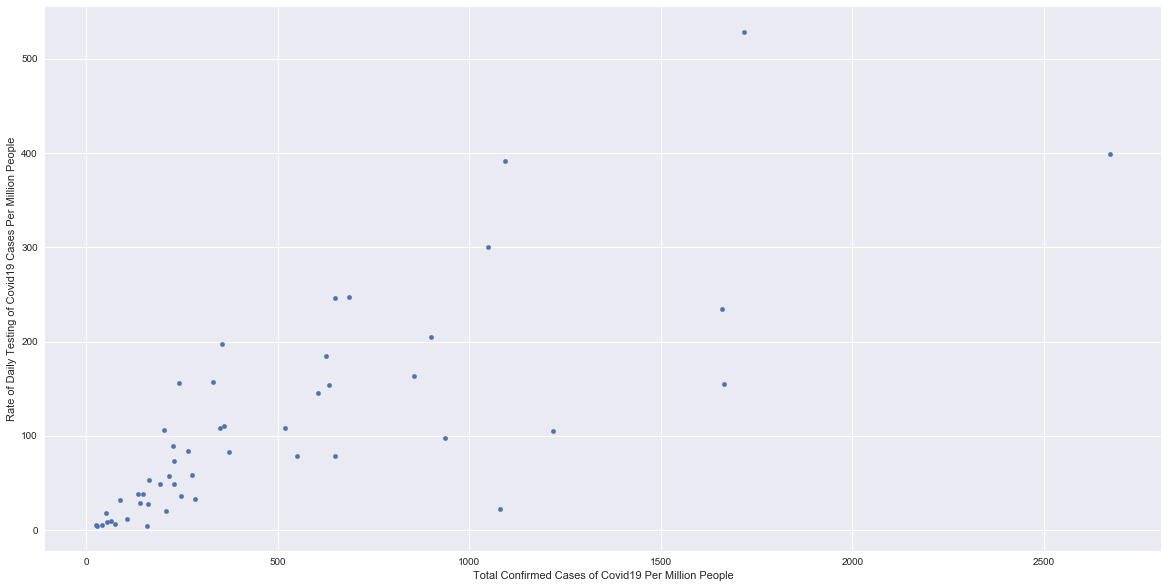

In [613]:
f, ax = plt.subplots(figsize=(20,10))
testing_per_capita.plot.scatter(x='total', y='daily_test', ax=ax)
ax.set_ylabel("Rate of Daily Testing of Covid19 Cases Per Million People")
ax.set_xlabel("Total Confirmed Cases of Covid19 Per Million People")

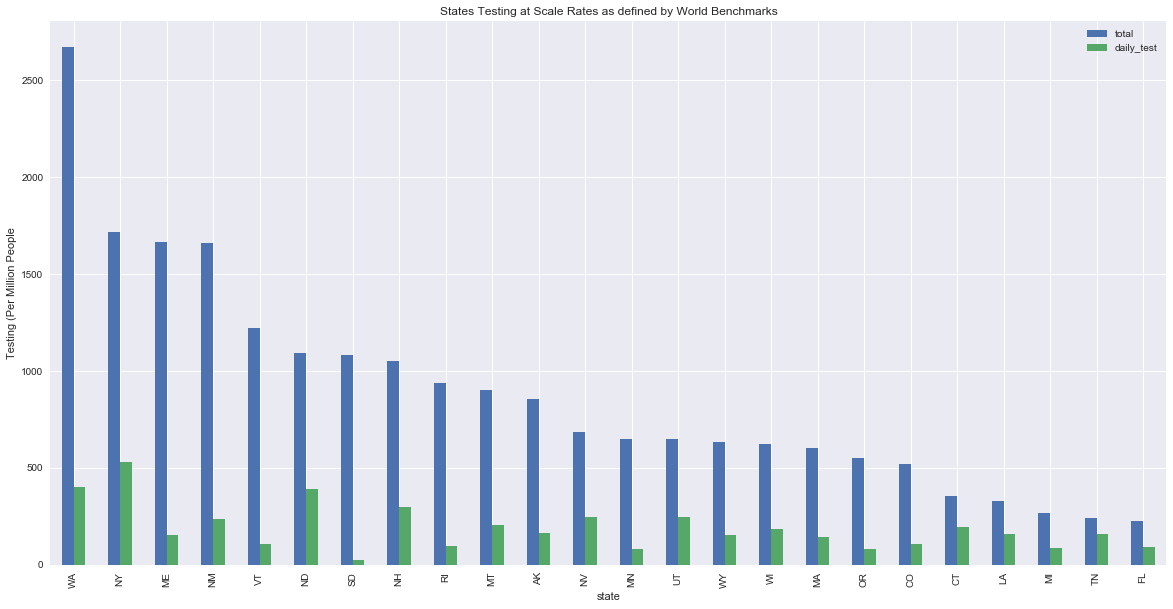

In [614]:
f, ax = plt.subplots(figsize= (20,10))
title = "States Testing at Scale Rates as defined by World Benchmarks"
states_testing_top = testing_per_capita.loc[states_scaling].sort_values(by="total", ascending=False)
ax.set_title(title)
ax.set_ylabel("Testing (Per Million People")
states_testing_top.plot(kind='bar', ax=ax)
plt.savefig("{}.jpg".format(title))

In [615]:
positives = daily_per_capita_M.loc[states_testing_top.index].reset_index().groupby('state').last()['positive']

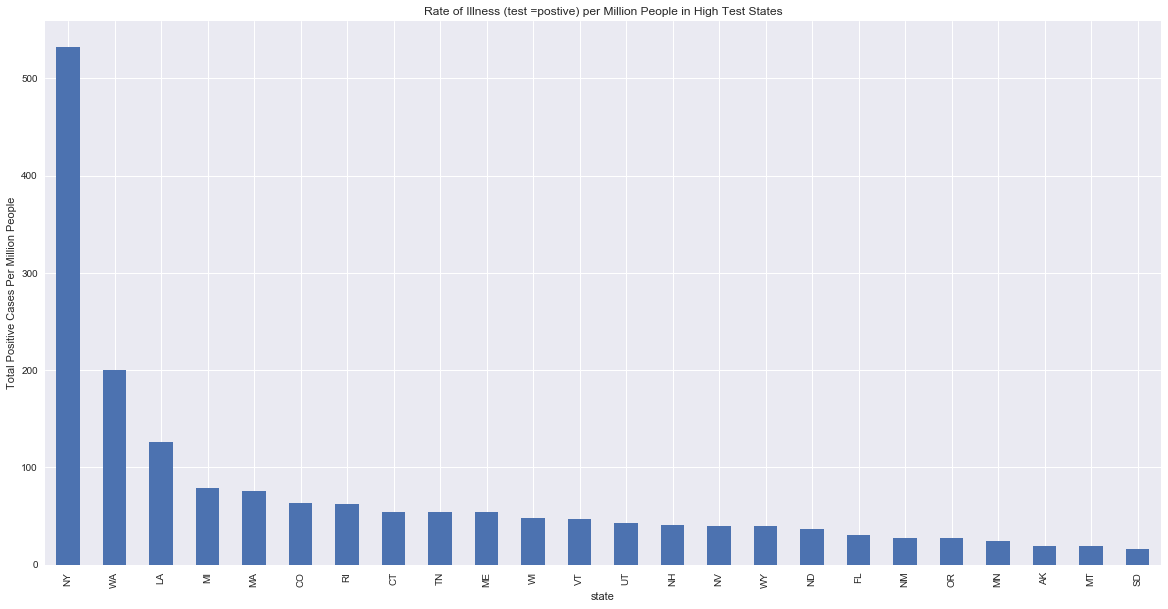

In [616]:
f, ax = plt.subplots(figsize=(20,10))
title = "Rate of Illness (test =postive) per Million People in High Test States"
daily
positives.sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title(title)
ax.set_ylabel("Total Positive Cases Per Million People")
plt.savefig("{}.jpg".format(title))

In [617]:
#pull in South Korea data
path = "csse_covid_19_data/csse_covid_19_time_series/"
Confirmed = "time_series_19-covid-Confirmed.csv"
Deaths = "time_series_19-covid-Deaths.csv"
Recovered = "time_series_19-covid-Recovered.csv"
files = {"Confirmed": Confirmed,
        "Deaths": Deaths,
        "Recovered": Recovered}

for k,v in files.items():
    df = pd.read_csv(os.path.join(path, v))
    files.update({k: df})
    
confirmed= files['Confirmed']
deaths = files['Deaths']
recovered = files['Recovered']
confirmed = confirmed[confirmed["Country/Region"].str.contains("Korea")]
deaths = deaths[deaths["Country/Region"].str.contains("Korea")]
recovered = recovered[recovered["Country/Region"].str.contains("Korea")]
sit_report = pd.concat([confirmed, deaths, recovered], keys = files.keys())
sit_report = sit_report.reset_index().set_index(["Country/Region", 'level_0']).iloc[:, 4:].T
sit_report.index.name = "Day"
ndx = pd.to_datetime(sit_report.index)
sit_report = sit_report.set_index(ndx)

In [618]:
date_start = pd.datetime(2020, 3, 4)

In [619]:
confirmed = files['Confirmed']
italy = confirmed[confirmed["Country/Region"].str.contains("Italy")].set_index("Country/Region", drop=True).iloc[:,4:].T
italy.index.name="Day"

italy.name = "Italy"
ndx = pd.to_datetime(italy.index)
italy = italy.set_index(ndx)
italy_pop = italy*1e6/60.5e6
italy_pop = italy_pop.loc[italy_pop.index >= date_start]

In [620]:
sit_report['population']=51.5e6
sit_report.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [621]:
sk_confirmed = sit_report.T.reset_index(0, drop=True).T[['Confirmed', 'Deaths', 'Recovered']].div(sit_report.iloc[:, 3]/1e6, axis=0)['Confirmed']
sk_confirmed = sk_confirmed.to_frame()

In [622]:
sk_confirmed.columns = ["South Korea"]
#limit to US dates
sk_confirmed = sk_confirmed.loc[sk_confirmed.index>= date_start]
sk_confirmed

,South Korea
Day,
2020-03-04,109.145631
2020-03-05,118.213592
2020-03-06,128.019417
2020-03-07,136.718447
2020-03-08,142.019417
2020-03-09,145.203883
2020-03-10,145.883495
2020-03-11,150.582524
2020-03-12,152.796117


In [623]:
daily_per_capita_M

positive    negative    pending  death       total  \
state date                                                              
AK    2020-03-06   0.000000   10.935759   1.366970    NaN   12.302729   
      2020-03-07   0.000000   16.403639   2.733940    NaN   19.137579   
      2020-03-08   0.000000   19.137579   8.201819    NaN   27.339398   
      2020-03-09   0.000000   31.440308  12.302729    NaN   43.743037   
      2020-03-10   0.000000   31.440308  12.302729    NaN   43.743037   
...                     ...         ...        ...    ...         ...   
WY    2020-03-17  17.278349  164.144316        NaN    NaN  181.422665   
      2020-03-18  25.917524  307.554613        NaN    NaN  333.472136   
      2020-03-19  31.101028  468.243258        NaN    NaN  499.344287   
      2020-03-20  32.828863  571.913353        NaN    NaN  604.742216   
      2020-03-21  39.740203  756.791687        NaN    NaN  796.531890   

                  daily_test   bool  test_scale_ndx  
state date                                           
AK    2020-03-06         NaN  False             NaN  
      2020-03-07    6.834850  False             NaN  
      2020-03-08    8.201819  False             NaN  
      2020-03-09   16.403639  False             NaN  
      2020-03-10    0.000000  False             NaN  
...                      ...    ...             ...  
WY    2020-03-17  176.239160  False             NaN  
      2020-03-18  152.049471  False             NaN  
      2020-03-19  165.872151  False             NaN  
      2020-03-20  105.397929   True             0.0  
      2020-03-21  191.789674   True             1.0  

[828 rows x 8 columns]

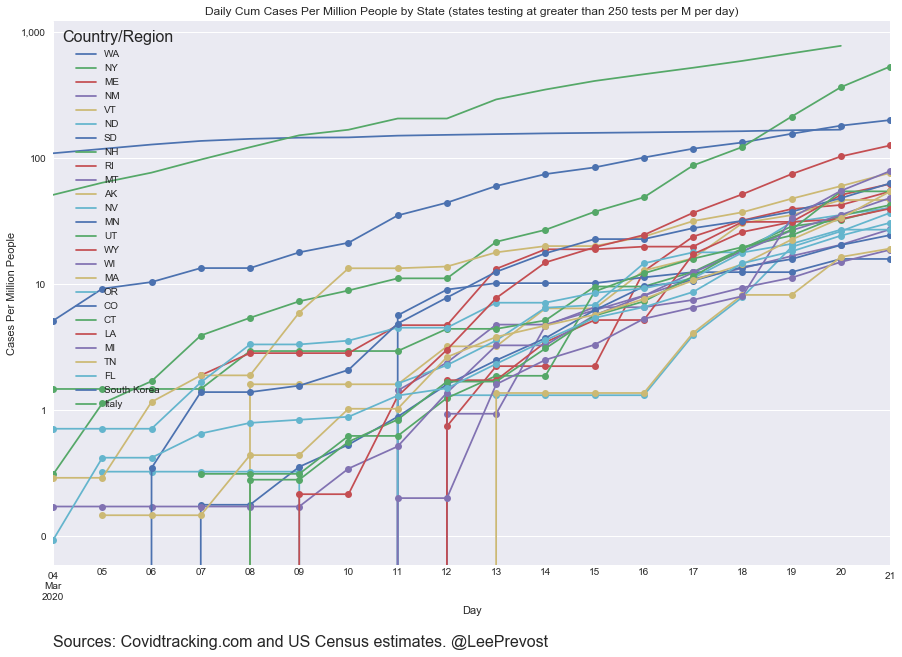

In [626]:

f, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({"font.size": 16})
#plt.style.use("seaborn")
for ndx, state in enumerate(states_testing_top.index):
    daily_per_capita_M.loc[states_testing_top.index[ndx]]['positive'].plot(logy=True, label=state, marker='o', legend=True, ax=ax)
sk_confirmed.plot(logy=True, label="South Korea", marker='+', legend=True, ax=ax)
italy_pop.plot(logy=True, label="Italy", marker='x', legend=True, ax=ax)
ax.set_ylabel("Cases Per Million People")
note = """Sources: Covidtracking.com and US Census estimates. @LeePrevost"""
plt.annotate(note, (0,0), (0, -70), xycoords='axes fraction', textcoords='offset points', va='top')
title = "Daily Cum Cases Per Million People by State (states testing at greater than 250 tests per M per day)"
plt.title(title)
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("{}.jpg".format(title))